# Document classification: PRA assignment 2

> Author: [Aditya Godse](https://adimail.github.io/)

Develop a text classification model that can effectively identify, extract features, and classify documents from the 20 Newsgroups dataset into one of the 20 predefined categories using  pattern recognition techniques.

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Agenda for text classification system for the 20 Newsgroups dataset

- Data exploration
- Data preperation
- Feature Extraction
- Classification
    - Multinomial Naive Bayes (default)
    - Multinomial Logistic Regression
- Evaluation


The 20 newsgroups dataset is used in classification problems. The fetch_20newsgroups() function allows the loading of filenames and data from the 20 newsgroups dataset. It has 20 classes, 18846 observations, and features in the form of strings.

It downloads the dataset from the original 20 newsgroups website and caches it locally.

In [2]:
data = fetch_20newsgroups()

# Data exploration

In [3]:
category_names = data.target_names

In [4]:
len(category_names)

20

In [5]:
category_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
print(data['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [7]:
len(data.data)

11314

In [8]:
print(f"Total number of documents: {len(data.data)}")
print(f"Average document length: {np.mean([len(doc.split()) for doc in data.data]):.2f} words")

Total number of documents: 11314
Average document length: 287.47 words


In [9]:
category_dist = pd.Series(data.target).value_counts().sort_index()

for category, count in zip(category_names, category_dist.values):
    print(f"{count}, \t {category}")

480, 	 alt.atheism
584, 	 comp.graphics
591, 	 comp.os.ms-windows.misc
590, 	 comp.sys.ibm.pc.hardware
578, 	 comp.sys.mac.hardware
593, 	 comp.windows.x
585, 	 misc.forsale
594, 	 rec.autos
598, 	 rec.motorcycles
597, 	 rec.sport.baseball
600, 	 rec.sport.hockey
595, 	 sci.crypt
591, 	 sci.electronics
594, 	 sci.med
593, 	 sci.space
599, 	 soc.religion.christian
546, 	 talk.politics.guns
564, 	 talk.politics.mideast
465, 	 talk.politics.misc
377, 	 talk.religion.misc


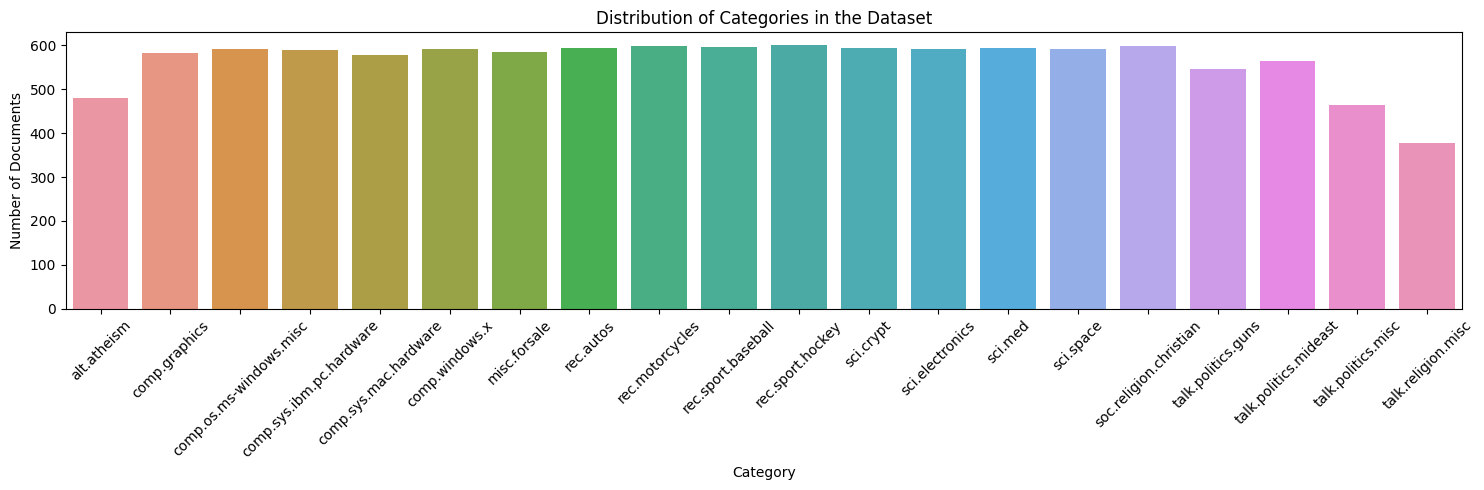

In [10]:
plt.figure(figsize=(15, 5))
category_dist = pd.Series(data.target).value_counts().sort_index()
sns.barplot(x=category_dist.index, y=category_dist.values)
plt.xticks(range(len(category_names)), category_names, rotation=45)
plt.title('Distribution of Categories in the Dataset')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.tight_layout()
plt.show()

In [11]:
def display_sample_doc(doc_id=1):
    print(f"\n\nCategory: {category_names[doc_id]}")
    print("-" * 50)    
    print(f"\nSample document:\n\n{data.data[doc_id][:600]}...")
    print("-" * 30)

In [12]:
display_sample_doc(1)



Category: comp.graphics
--------------------------------------------------

Sample document:

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functiona...
------------------------------


In [13]:
display_sample_doc(7)



Category: rec.autos
--------------------------------------------------

Sample document:

From: bgrubb@dante.nmsu.edu (GRUBB)
Subject: Re: IDE vs SCSI
Organization: New Mexico State University, Las Cruces, NM
Lines: 44
Distribution: world
NNTP-Posting-Host: dante.nmsu.edu

DXB132@psuvm.psu.edu writes:
>In article <1qlbrlINN7rk@dns1.NMSU.Edu>, bgrubb@dante.nmsu.edu (GRUBB) says:
>>In PC Magazine April 27, 1993:29 "Although SCSI is twice as fasst as ESDI,
>>20% faster than IDE, and support up to 7 devices its acceptance ...has   
>>long been stalled by incompatability problems and installation headaches."
                                                                      
>I love ...
------------------------------


# Data preperation for modelling

Now let's prepare the data for modeling:

In [14]:
data.data[0][:500]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a m"

In [15]:
print(data.data[0][:500])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a m


### Observations:

- The dataset consists mostly of emails, and to achieve good scores, we need to filter out the body of the emails.

### `remove` Parameter in fetch_20newsgroups()

The `remove` parameter is a tuple with the following options:

- **Default:** `removetuple=()`
- May contain any subset of:
  - `'headers'`: Removes newsgroup headers.
  - `'footers'`: Removes blocks at the ends of posts that resemble signatures.
  - `'quotes'`: Removes lines that appear to quote another post.

### Notes:

1. **Purpose of Removal**:
   - Prevent classifiers from overfitting to metadata instead of focusing on the content.

2. **Behavior**:
   - `'headers'`: Detected and removed using an exact standard.
   - `'footers'` & `'quotes'`: Filtered heuristically and may not always be accurate.

### Example Usage in Code:

```python
from sklearn.datasets import fetch_20newsgroups

# Removing headers, footers, and quotes from the dataset
categories = ['alt.atheism', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories,
                                      remove=('headers', 'footers', 'quotes'))

print("Sample Data:", newsgroups_train.data[:1])
```

In [16]:
data = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

In [17]:
def display_sample_doc(doc_id=1):
    print(f"\n\nCategory: {category_names[doc_id]}")
    print("-" * 50)    
    print(f"\nSample document:\n\n{data.data[doc_id][:600]}...")
    print("-" * 30)

In [18]:
display_sample_doc(1)



Category: comp.graphics
--------------------------------------------------

Sample document:

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks....
------------------------------


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    data.data, 
    data.target,
    test_size=0.2,
)

# Feature Extraction

## What is TF-IDF

TF-IDF stands for term frequency-inverse document frequency, and it's a measure of how important a word is to a document in a collection of documents. It's used in information retrieval and machine learning to quantify the relevance of words, phrases, and lemmas in a document.

TF-IDF is useful because it adjusts for the fact that some words appear more frequently than others. For example, if you only used term frequency to measure importance, you might over-emphasize terms like "a", "the", and "of" that appear often but don't carry much information. 

In [20]:
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2
)

Here’s what each parameter in `TfidfVectorizer` does:

- `max_features=5000`: Limits the number of features (unique words or n-grams) to the top 5000 based on term frequency across the dataset.
- `stop_words='english'`: Removes common English stop words (e.g., "the," "and," "is") from the vocabulary.
- `ngram_range=(1, 2)`: Considers both unigrams (single words) and bigrams (two consecutive words) as features.
- `min_df=2`: Ignores terms that appear in fewer than 2 documents to reduce noise.

In [21]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

1. This step first "fits" the TfidfVectorizer on the training data X_train, meaning it learns the vocabulary (based on the parameters defined such as max_features, stop_words, ngram_range, and min_df). Then, it transforms the X_train data into a TF-IDF matrix, where each document is represented as a vector of TF-IDF scores for the selected features
2. After fitting the vectorizer on the training data, we use the transform method to apply the same transformation to the test data X_test. This ensures that the test data is represented using the same vocabulary and feature extraction scheme as the training data (but without "fitting" the vectorizer again, so no data leakage occurs).

Once we’ve trained a model and used the `TfidfVectorizer` to transform this training data, we must use the same vectorizer to transform any new data (like test data or live data). This ensures that the model sees the same features during testing or inference that it saw during training.

### Why use the same vectorizer?
Vocabulary consistency: The vectorizer learns the vocabulary from the training data (after applying parameters like max_features, stop_words, etc.). If you use a different vectorizer or refit it on the test data, it might have a different vocabulary, which could lead to mismatched features for the model.

Avoiding data leakage: By using the same vectorizer (without refitting it), you avoid leaking information from the test data into the training process, which can lead to overfitting.

In [22]:
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print("\nSample features:")
print(list(tfidf.vocabulary_.keys())[:10])

Vocabulary size: 5000

Sample features:
['dc', 'today', 'isn', 'suitable', 'funds', 'rocket', 'goal', 'did', 'lot', 'going']


In [23]:
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Testing data shape: {X_test_tfidf.shape}")

Training data shape: (9051, 5000)
Testing data shape: (2263, 5000)


In [24]:
# First 20 words in our vocabluary
list(tfidf.vocabulary_.keys())[:20]

['dc',
 'today',
 'isn',
 'suitable',
 'funds',
 'rocket',
 'goal',
 'did',
 'lot',
 'going',
 'reports',
 'soon',
 'bush',
 'right',
 'people',
 'paying',
 'public',
 'support',
 'critical',
 'politics']

Example usage of our vectoriser

In [25]:
tfidf.transform(["Aditya"])

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

The output `<1x5000 sparse matrix with 0 stored elements>` means that the vectorizer did not find any matching features (terms or n-grams) from the word `"Aditya"` in the vocabulary it learned from the training data.

In [26]:
tfidf.transform(["Signals"])

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

The output <1x5000 sparse matrix with 1 stored elements> means that the vectorizer has transformed the word "Signals" into a sparse matrix with 1 non-zero element.

- 1x5000 Sparse Matrix: The transformed data is a sparse matrix with 1 row and 5000 columns. Each of these 5000 columns corresponds to one of the top 5000 features (words or n-grams) in the vocabulary learned by the TfidfVectorizer. Since the input is just a single word "Signals", there will only be one non-zero value in the matrix (if the word exists in the vocabulary).

- 1 Stored Element: This means that only one element in the matrix has a non-zero value, which indicates that the word "Signals" is part of the learned vocabulary, and the matrix stores its TF-IDF score at the corresponding feature index.

- Sparse Matrix: Since the vectorizer learned a vocabulary with 5000 features, most of the entries for this single document will be zero (i.e., the matrix will be mostly empty), and only the value corresponding to the feature for "Signals" will have a non-zero value.

In [27]:
X_signals_tfidf = tfidf.transform(["Signals"])
dense_matrix = X_signals_tfidf.toarray()
dense_matrix

# This will show the TF-IDF score for "Signals" along with zeros for all the other terms. The position of the non-zero value corresponds to the feature index for "Signals" in the learned vocabulary.

array([[0., 0., 0., ..., 0., 0., 0.]])

In [28]:
def print_tfidf_non_zero_values(text):
    X_tfidf = tfidf.transform([text])
    dense_matrix = X_tfidf.toarray()
    non_zero_indices = dense_matrix.nonzero()[1]
    for idx in non_zero_indices:
        word = list(tfidf.vocabulary_.keys())[idx]
        value = dense_matrix[0][idx]
        print(f"Word: '{word}' | TF-IDF Value: {value}")

In [29]:
print_tfidf_non_zero_values("My bad")

Word: 'core' | TF-IDF Value: 1.0


In [30]:
print_tfidf_non_zero_values("Computer")

Word: 'military' | TF-IDF Value: 1.0


## What is MultinomialNB

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

- Works well with text data where features are word counts
- Fast training and prediction
- Performs well even with small training datasets
- Good with high-dimensional data (many words)

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

example_reviews = [
    # College (0)
    "Students should learn DevOps first before learning MLOps",
    "Final year projects are crucial for gaining practical experience in computer science",
    "Campus placements help students secure jobs before graduation",
    "The library resources are essential for research and academic success",
    "Attending programming workshops enhances technical skills",
    
    # AISSMS IOIT (1)
    "AISSMS IOIT in Pune offers excellent computer engineering program",
    "AISSMS IOIT's annual tech fest TENET attracts participants from all over Maharashtra",
    "The placement cell at AISSMS IOIT consistently achieves good placement records, but its down this year",
    "AISSMS IOIT's Kennedy Road campus has modern computer laboratories",
    
    # Movies (2)
    "The new superhero movie has amazing special effects and action sequences",
    "This romantic comedy perfectly captures modern dating struggles",
    "The documentary about climate change was eye-opening and informative",
    "The thriller kept me on the edge of my seat until the very end",
    "The animation quality in the latest Pixar film is groundbreaking",
    
    # Music (3)
    "The new indie band's acoustic album has beautiful harmonies",
    "This rap artist's lyrics tackle important social issues",
    "The classical concert at the symphony hall was breathtaking",
    "La la land is the best musical movie from 21st century",
    "The Joker 2024 is the worst musical movie of the 21st century"
]

# Labels: 0=College, 1=AISSMS, 2=Movies, 3=Music
example_labels = [0, 0, 0, 0, 0, 
                 1, 1, 1, 1, 
                 2, 2, 2, 2, 2, 
                 3, 3, 3, 3, 3]

In [32]:
example_vectorizer = CountVectorizer()
example_X = example_vectorizer.fit_transform(example_reviews)

In [33]:
example_model = MultinomialNB()
example_model.fit(example_X, example_labels)

MultinomialNB()

In [34]:
new_review = ["Aditya godse studies in AISSMS IOIT"]
example_X_new = example_vectorizer.transform(new_review)

prediction = example_model.predict(example_X_new)
probabilities = example_model.predict_proba(example_X_new)

In [35]:
prediction

array([1])

In [36]:
print("\nProbabilities for each category:")
for i, prob in enumerate(probabilities[0]):
    print(f"Category {i}: {prob:.3f}")


Probabilities for each category:
Category 0: 0.046
Category 1: 0.893
Category 2: 0.040
Category 3: 0.021


This shows the probability that the model thinks in which category this new example belongs

# Modelling

Multinomial Naive Bayes is a probabilistic classifier to calculate the probability distribution of text data, which makes it well-suited for data with features that represent discrete frequencies or counts of events in various natural language processing (NLP) tasks.

In [37]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [38]:
y_pred = model.predict(X_test_tfidf)
y_pred

array([12, 16, 15, ..., 11,  1, 15])

# Evaluation

In [39]:
text_vectorized = tfidf.transform(["I love my computer"])
sampleprediction = model.predict(text_vectorized)

In [40]:
sampleprediction

array([1])

In [41]:
data.target_names[sampleprediction[0]]

'comp.graphics'

In [42]:
def predictcategory(inputstring):
    inputstring = [inputstring]
    vectorised_text = tfidf.transform(inputstring)
    modelprediction = model.predict(vectorised_text)
    return data.target_names[modelprediction[0]]

In [43]:
predictcategory("I do not have faith in god, I have faith in myself. I do not believe someone is comming to save us from our miseries")

'soc.religion.christian'

In [44]:
predictcategory("My name is aditya godse and I use macos computer")

'comp.sys.ibm.pc.hardware'

In [45]:
print(classification_report(y_test, y_pred, target_names=category_names))

                          precision    recall  f1-score   support

             alt.atheism       0.54      0.34      0.42        94
           comp.graphics       0.53      0.59      0.56       103
 comp.os.ms-windows.misc       0.65      0.67      0.66       116
comp.sys.ibm.pc.hardware       0.62      0.66      0.64       117
   comp.sys.mac.hardware       0.81      0.66      0.73       119
          comp.windows.x       0.74      0.74      0.74       119
            misc.forsale       0.76      0.71      0.73       128
               rec.autos       0.61      0.64      0.63       121
         rec.motorcycles       0.64      0.62      0.63       109
      rec.sport.baseball       0.80      0.76      0.78       123
        rec.sport.hockey       0.50      0.89      0.64       110
               sci.crypt       0.77      0.78      0.77       125
         sci.electronics       0.70      0.59      0.64       120
                 sci.med       0.78      0.73      0.75       122
         

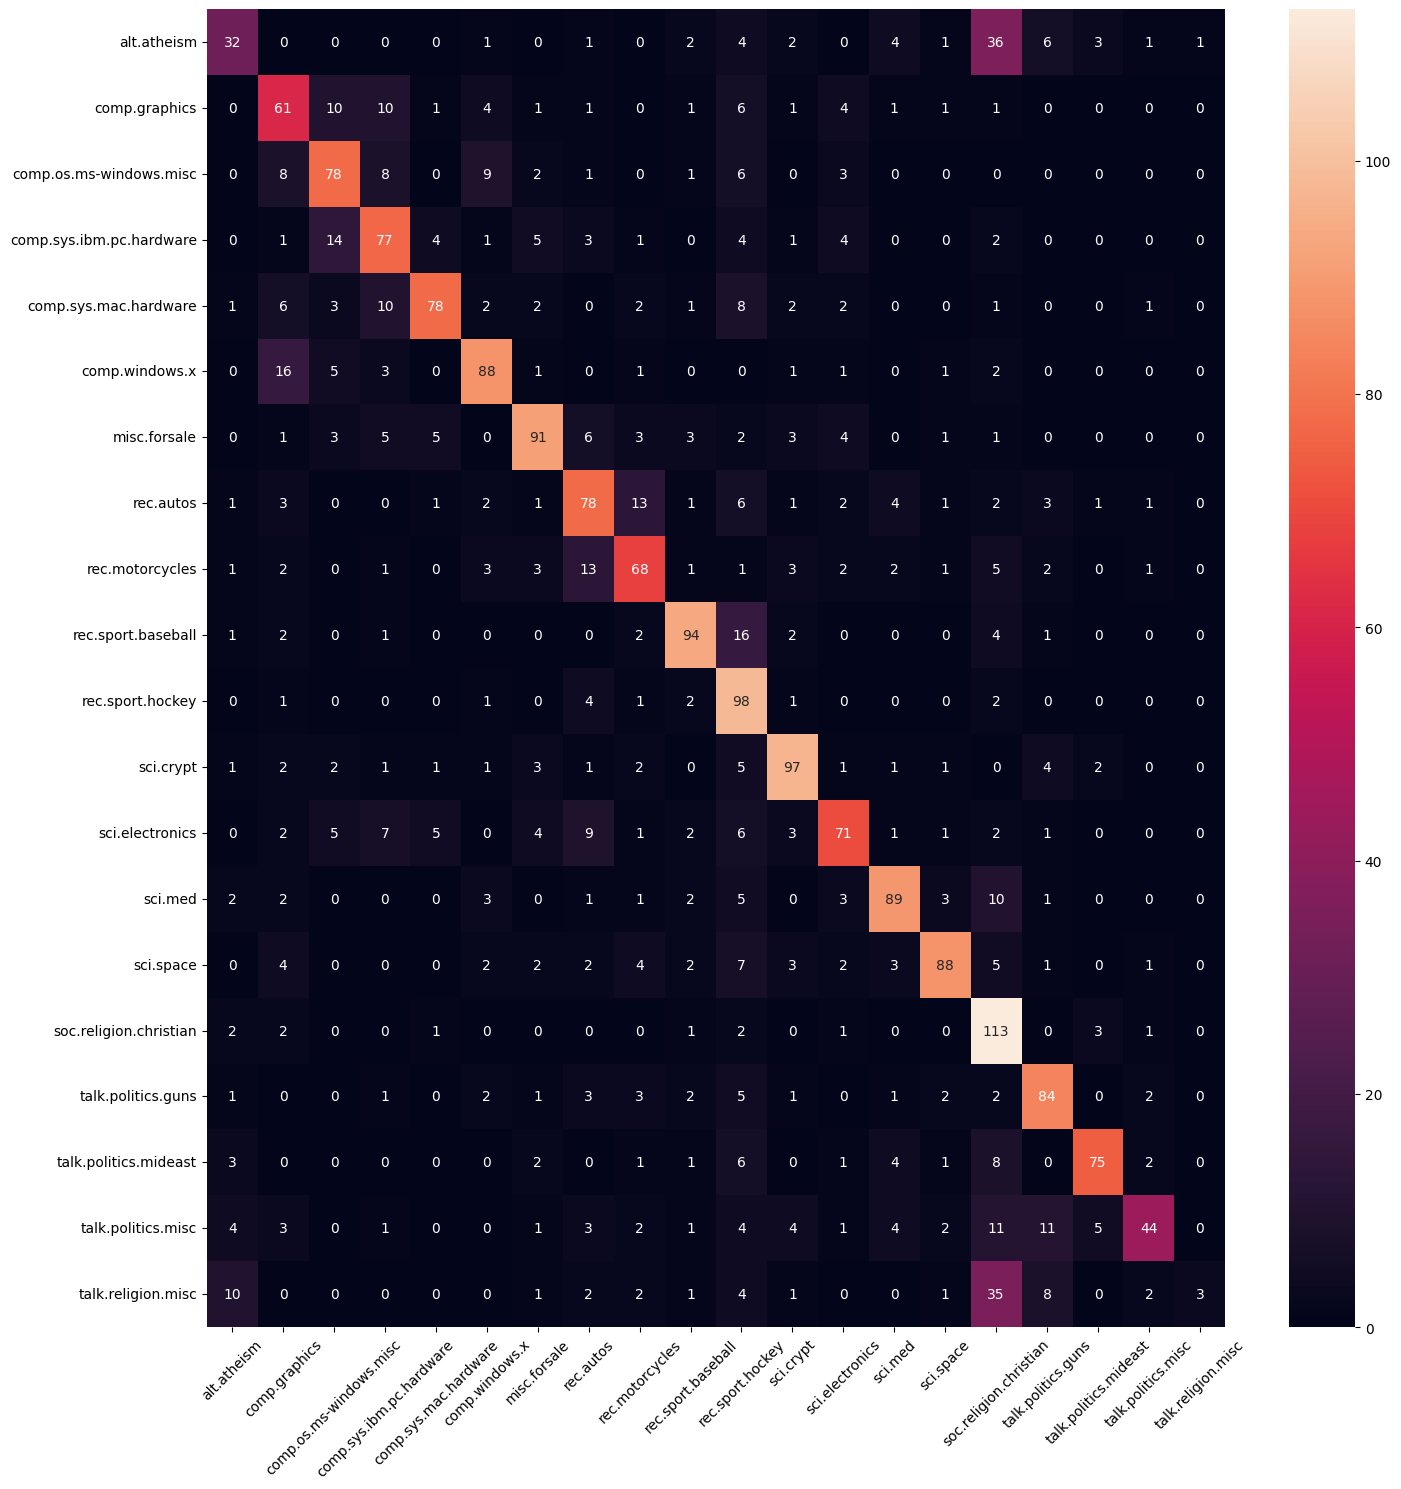

In [46]:
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=category_names,
            yticklabels=category_names)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

In [47]:
def print_top_features(category_id, n_features=10):
    feature_names = np.array(tfidf.get_feature_names_out())
    log_probs = model.feature_log_prob_[category_id]
    top_indices = np.argsort(log_probs)[-n_features:]
    
    print(f"\nTop features for category '{category_names[category_id]}':")
    for idx in reversed(top_indices):
        print(f"{feature_names[idx]}: {np.exp(log_probs[idx]):.4f}")

for category_id in range(len(category_names)):
    print_top_features(category_id)


Top features for category 'alt.atheism':
god: 0.0024
don: 0.0018
people: 0.0018
think: 0.0017
atheism: 0.0016
religion: 0.0016
just: 0.0015
say: 0.0013
does: 0.0013
islam: 0.0013

Top features for category 'comp.graphics':
graphics: 0.0029
thanks: 0.0021
image: 0.0020
files: 0.0019
file: 0.0018
program: 0.0016
know: 0.0015
format: 0.0015
looking: 0.0015
does: 0.0014

Top features for category 'comp.os.ms-windows.misc':
windows: 0.0063
file: 0.0028
dos: 0.0023
files: 0.0022
drivers: 0.0019
thanks: 0.0018
use: 0.0018
card: 0.0018
driver: 0.0018
using: 0.0016

Top features for category 'comp.sys.ibm.pc.hardware':
drive: 0.0031
card: 0.0026
scsi: 0.0026
controller: 0.0022
bus: 0.0020
ide: 0.0020
pc: 0.0019
thanks: 0.0018
monitor: 0.0017
drives: 0.0016

Top features for category 'comp.sys.mac.hardware':
mac: 0.0036
apple: 0.0028
drive: 0.0022
quadra: 0.0016
thanks: 0.0016
problem: 0.0016
simms: 0.0016
use: 0.0015
does: 0.0015
know: 0.0015

Top features for category 'comp.windows.x':
window

In [48]:
print(data.data[10])

I have a line on a Ducati 900GTS 1978 model with 17k on the clock.  Runs
very well, paint is the bronze/brown/orange faded out, leaks a bit of oil
and pops out of 1st with hard accel.  The shop will fix trans and oil 
leak.  They sold the bike to the 1 and only owner.  They want $3495, and
I am thinking more like $3K.  Any opinions out there?  Please email me.
Thanks.  It would be a nice stable mate to the Beemer.  Then I'll get
a jap bike and call myself Axis Motors!

-- 
-----------------------------------------------------------------------
"Tuba" (Irwin)      "I honk therefore I am"     CompuTrac-Richardson,Tx
irwin@cmptrc.lonestar.org    DoD #0826          (R75/6)


In [49]:
predictcategory("Politics")

'talk.politics.guns'

# Exporting model for [website](https://adimail.github.io/fetch_20newsgroups-document-classification)

In [50]:
import joblib
import os

save_dir = './model_data'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

joblib.dump(model, os.path.join(save_dir, 'model.pkl'))
joblib.dump(tfidf, os.path.join(save_dir, 'vectorizer.pkl'))

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


In [51]:
import json

vocab = {str(key): int(value) for key, value in tfidf.vocabulary_.items()}
classes = [int(cls) for cls in model.classes_]

with open(os.path.join(save_dir, 'vocab.json'), 'w') as f:
    json.dump(vocab, f)

with open(os.path.join(save_dir, 'classes.json'), 'w') as f:
    json.dump(classes, f)

print("Vocabulary and classes exported as JSON.")

Vocabulary and classes exported as JSON.


## Testing the exported model in python environment

In [52]:
loaded_model = joblib.load(os.path.join(save_dir, 'model.pkl'))
loaded_vectorizer = joblib.load(os.path.join(save_dir, 'vectorizer.pkl'))

In [53]:
text = ["My name is aditya and I like bikes"]
vectorized_text = loaded_vectorizer.transform(text)
prediction = loaded_model.predict(vectorized_text)

print("Predicted category:", category_names[prediction[0]])

Predicted category: rec.motorcycles


# Keras model

## With GlobalAveragePooling1D

In [54]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary size to 5000
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100  # maximum length of each sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [55]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, GlobalAveragePooling1D
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(input_dim=5000,  # Size of the vocabulary
                    output_dim=128,  # Size of the embedding vectors
                    input_length=max_sequence_length))  # Length of input sequences

# Use Global Average Pooling for testig purposes
model.add(GlobalAveragePooling1D())  # Reduces sequence dimensions to 1D
model.add(Dense(128, activation='relu'))  # Hidden layer
model.add(Dense(len(classes), activation='softmax'))  # Output layer (softmax for multi-class)

model.compile(optimizer=Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [56]:
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0896 - loss: 2.9472 - val_accuracy: 0.2435 - val_loss: 2.5112
Epoch 2/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2986 - loss: 2.3078 - val_accuracy: 0.4096 - val_loss: 1.9374
Epoch 3/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4897 - loss: 1.7065 - val_accuracy: 0.4878 - val_loss: 1.7166
Epoch 4/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5936 - loss: 1.3656 - val_accuracy: 0.5493 - val_loss: 1.5209
Epoch 5/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6899 - loss: 1.1231 - val_accuracy: 0.5378 - val_loss: 1.5619


In [57]:
score = model.evaluate(X_test_pad, y_test, batch_size=32)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5246 - loss: 1.5996
Test Loss: 1.5618706941604614
Test Accuracy: 0.5377817153930664


## with LSTM

LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) that is particularly effective in learning from sequential data. RNNs, in general, are used to process sequences (e.g., time series, text, speech), where the output of the model at each time step depends not only on the current input but also on the previous time steps (the "memory" of the sequence).

Why Use LSTM?

LSTM networks excel at tasks where long-term dependencies matter. In text or sequence modeling (such as language translation, sentiment analysis, and document classification), LSTM is commonly used because:

- Sequential Data: LSTMs are designed to handle sequences effectively (like sentences, time series, or speech).
- Learning Dependencies: LSTMs can learn both short- and long-term dependencies in the input sequence.

Example Use Cases:
- Text Generation: Predicting the next word in a sentence given the previous ones.
- Sentiment Analysis: Classifying the sentiment of a sentence or document.
- Machine Translation: Translating text from one language to another.

In [58]:
from keras.layers import LSTM

# LSTM layer (instead of GlobalAveragePooling1D)
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [59]:
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 34s 112ms/step - accuracy: 0.0806 - loss: 2.8661 - val_accuracy: 0.1745 - val_loss: 2.4186
Epoch 2/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.2447 - loss: 2.1790 - val_accuracy: 0.2961 - val_loss: 2.0743
Epoch 3/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.4058 - loss: 1.7105 - val_accuracy: 0.3522 - val_loss: 1.9863
Epoch 4/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.5365 - loss: 1.3395 - val_accuracy: 0.4308 - val_loss: 1.8493
Epoch 5/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.6409 - loss: 1.0543 - val_accuracy: 0.4476 - val_loss: 1.9259


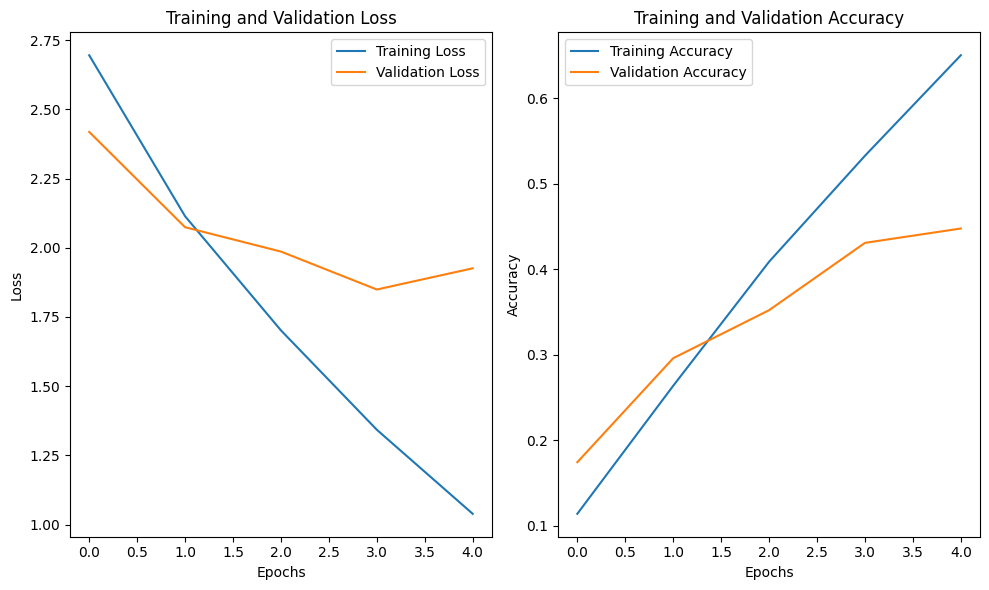

In [60]:
history_dict = history.history

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

if 'accuracy' in history_dict and 'val_accuracy' in history_dict:
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [61]:
def predict_category(text):
    text_tokenized = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_tokenized, maxlen=100)
    prediction = model.predict(text_padded)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_category = category_names[predicted_class[0]]
    
    return predicted_category

In [62]:
predict_category("My name is adity and I love computers")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


'comp.sys.mac.hardware'

In [63]:
predict_category("Does god exists?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'talk.religion.misc'

In [64]:
predict_category("I want to own a bike and travel india")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


'rec.motorcycles'

In [65]:
predict_category("The Super Bowl is known for its halftime performances.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


'sci.space'

In [66]:
predict_category("The Super Bowl is one of the most-watched single sporting events in the world. It's also often the most-watched American broadcast of the year.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


'rec.sport.baseball'

## Save keras model

In [67]:
model.save('./model_data/model.keras')

In [68]:
model.save('./model_data/model.h5')

## Test loaded model

In [69]:
import tensorflow as tf
keras_loaded_model = tf.keras.models.load_model('./model_data/model.keras')

In [70]:
keras_loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,372,030 (9.05 MB)

 Trainable params: 790,676 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,581,354 (6.03 MB)

In [71]:
text = "I love solving writing computer software"

text_tokenized = tokenizer.texts_to_sequences([text])
text_padded = pad_sequences(text_tokenized, maxlen=100)

In [72]:
prediction = model.predict(text_padded)
predicted_class = np.argmax(prediction, axis=1)
category_names[predicted_class[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'comp.os.ms-windows.misc'

In [73]:
total_params = keras_loaded_model.count_params()
trainable_params = np.sum([np.prod(w.shape) for w in keras_loaded_model.trainable_weights])
non_trainable_params = np.sum([np.prod(w.shape) for w in keras_loaded_model.non_trainable_weights])

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Total parameters: 790676
Trainable parameters: 790676
Non-trainable parameters: 0.0


## Exporting keras tokenizer

In [74]:
tokenizer_config = tokenizer.to_json()

with open('./model_data/tokenizer.json', 'w') as f:
    json.dump(tokenizer_config, f)

## Testing full loaded model and tokenizer

In [75]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

In [76]:
with open('./model_data/tokenizer.json', 'r') as f:
    tokenizer_config = json.load(f)

loaded_tokenizer = tokenizer_from_json(tokenizer_config)

In [77]:
text = "I love solving writing computer software"

text_tokenized = loaded_tokenizer.texts_to_sequences([text])
text_padded = pad_sequences(text_tokenized, maxlen=100)

prediction = keras_loaded_model.predict(text_padded)
predicted_class = np.argmax(prediction, axis=1)
category_names[predicted_class[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


'comp.os.ms-windows.misc'

In [78]:
category_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

# How to Import a Keras model into TensorFlow.js

In [79]:
!pip install tensorflowjs

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 18.1.0 which is incompatible.
distributed 2024.8.0 requires dask==2024.8.0, but you have dask 2024.12.1 which is incompatible.
pandas-gbq 0.23.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.


In [80]:
!mkdir tfjs_files

In [81]:
!tensorflowjs_converter --input_format=keras ./model_data/model.h5 ./tfjs_files

2024-12-31 21:10:15.284580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 21:10:15.310381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 21:10:15.318128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
failed to lookup keras version from the file,
    this is likely a weight only file
